# Mini Projekt 3
## Janek Filipecki, Wojtek Zarzecki
### Instrukcje
Tym razem zadanie polega na stworzeniu klasyfikatora obrazków działającego na 50 klasach z różnymi przedmiotami/zwierzętami itp. Do dyspozycji mają Państwo zbiór treningowy podzielony na odpowiednie podfoldery z klasami oraz zbiór testowy - bez podziału. Zbiór treningowy jest przygotowany w taki sposób by można go było łatwo załadować za pomocą klasy torchvision.ImageFolder wywołując np:
trainset = ImageFolder("data/train/", transform=train_transform)
Wówczas wszystkie przykłady zostaną przypisane do odpowiedniej klasy w zależności od tego w jakim podfolderze się znajdowały.
Jako że dane są bardzo duże to umieściłem je na OneDrive:
(train.zip i test_all.zip)

Proszę zwrócić szczególną uwagę na formę zwracanego rozwiązania, bo ostatnio większość z państwa zrobiła to byle jak i miałem bardzo dużo problemów z dodawaniem/usuwaniem niepotrzebnych wierszy itp. Tym razem nie będę poprawiał przesyłanych przez Państwa plików tylko wpisywał 0% accuracy!
W ramach rozwiązania, proszę oddać przez teamsy plik archiwum .zip z kodem (w formie notebooka, lub skryptu/skryptów .py) oraz plikiem .csv z predykcjami na zbiorze testowym. BEZ dodatkowych podfolderów i BEZ danych. W ramach predykcji proszę zapisać tym razem dwie kolumny (bez nagłówków):
Pierwszą kolumnę z nazwami plików testowych (uwaga pliki nazywają się np. 850043533599308.JPEG a nie 850043533599308.jpeg, 850043533599308.jpg czy 850043533599308). Proszę zwrócić na to uwagę bo mój skrypt ewaluacyjny inaczej nie zadziała.
Drugą kolumnę z wartościami oznaczającą predykcję numeru klasy. Klasy ponumerowane są zgodnie z numeracją ze zbioru treningowego (alfabetycznie startując od zera). Po utworzeniu datasetu w oparciu o ImageFolder klasy powinny się tak przypisać autoamtycznie - mogą to państwo sprawdzić wywołując trainset.classes.
Bardzo proszę nazywać wszystkie przesyłane pliki nazwiskami autorów (najlepiej alfabetycznie). Wyszukiwanie kto podpisał się "predictions.csv", a kto projekt_2.ipynb jest uciążliwe. Nazwę głównego archiwum zip, proszę dodatkowo rozpocząć od przedrostka poniedzialek_ lub piatek_, NIE pn,ptk albo coś w tym stylu.
Końcowe wyniki obliczał będę w oparciu o zwykłe accuracy (klasy są zbilansowane).
Uwaga: W zadaniu proszę nie wykorzystywać gotowych architektur o których wspominałem na zajęciach. Proszę też nie kopiować gotowych fragmentów (np. bloki resnetowe itp). Ostatnie laboratorium poświęcone będzie dokładnie temu zagadnieniu.

W MS Teams przydzieliłem zadanie wszystkim uczestnikom, ale bardzo proszę żeby tylko jeden (dowolny) członek zespołu je zwrócił (proszę się dogadać).
W razie pytań zapraszam do korespondencji lub na konsultacje.

### Importy

In [1]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import torch.nn.functional as F
import torchvision.models as models
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from torch.utils.data import random_split
from tqdm.notebook import tqdm

### Obsługa cuda

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

### Zaimportowanie datasetu oraz data augmentation

In [3]:
transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(0.5),
     transforms.RandomVerticalFlip(0.4),
     transforms.RandomRotation(20),
     transforms.ToTensor(),
     transforms.RandomErasing(0.3),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

BATCH_SIZE = 32

# from google.colab import files
# uploaded = files.upload()
raw_train_set = ImageFolder("data/train/", transform=transform)

In [4]:
raw_train_set.class_to_idx

{'acoustic': 0,
 'antenna': 1,
 'bacteria': 2,
 'battery': 3,
 'bean': 4,
 'beetle': 5,
 'bicycle': 6,
 'birch': 7,
 'bird': 8,
 'bomb': 9,
 'bread': 10,
 'bridge': 11,
 'camera': 12,
 'carbon': 13,
 'cat': 14,
 'corn': 15,
 'crab': 16,
 'crocodilian': 17,
 'echinoderm': 18,
 'egg': 19,
 'elephant': 20,
 'fish': 21,
 'flower': 22,
 'frog': 23,
 'fungus': 24,
 'gauge': 25,
 'hammer': 26,
 'icecream': 27,
 'kangaroo': 28,
 'memorial': 29,
 'monkey': 30,
 'motor': 31,
 'nest': 32,
 'palm': 33,
 'pizza': 34,
 'pot': 35,
 'printer': 36,
 'saw': 37,
 'snake': 38,
 'spice': 39,
 'spider': 40,
 'spoon': 41,
 'squash': 42,
 'swine': 43,
 'tea': 44,
 'tomato': 45,
 'towel': 46,
 'truck': 47,
 'turtle': 48,
 'worm': 49}

### Obsługa i analiza datasetu

#### Train-test split

In [5]:
def split_dataset(dataset, test_size, random_state):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=test_size, random_state=random_state)
    return Subset(dataset, train_idx), Subset(dataset, val_idx)

In [6]:
train_data, test_data = split_dataset(raw_train_set, 0.2, 42)

#### Dataloadery

In [7]:
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2) 

In [8]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

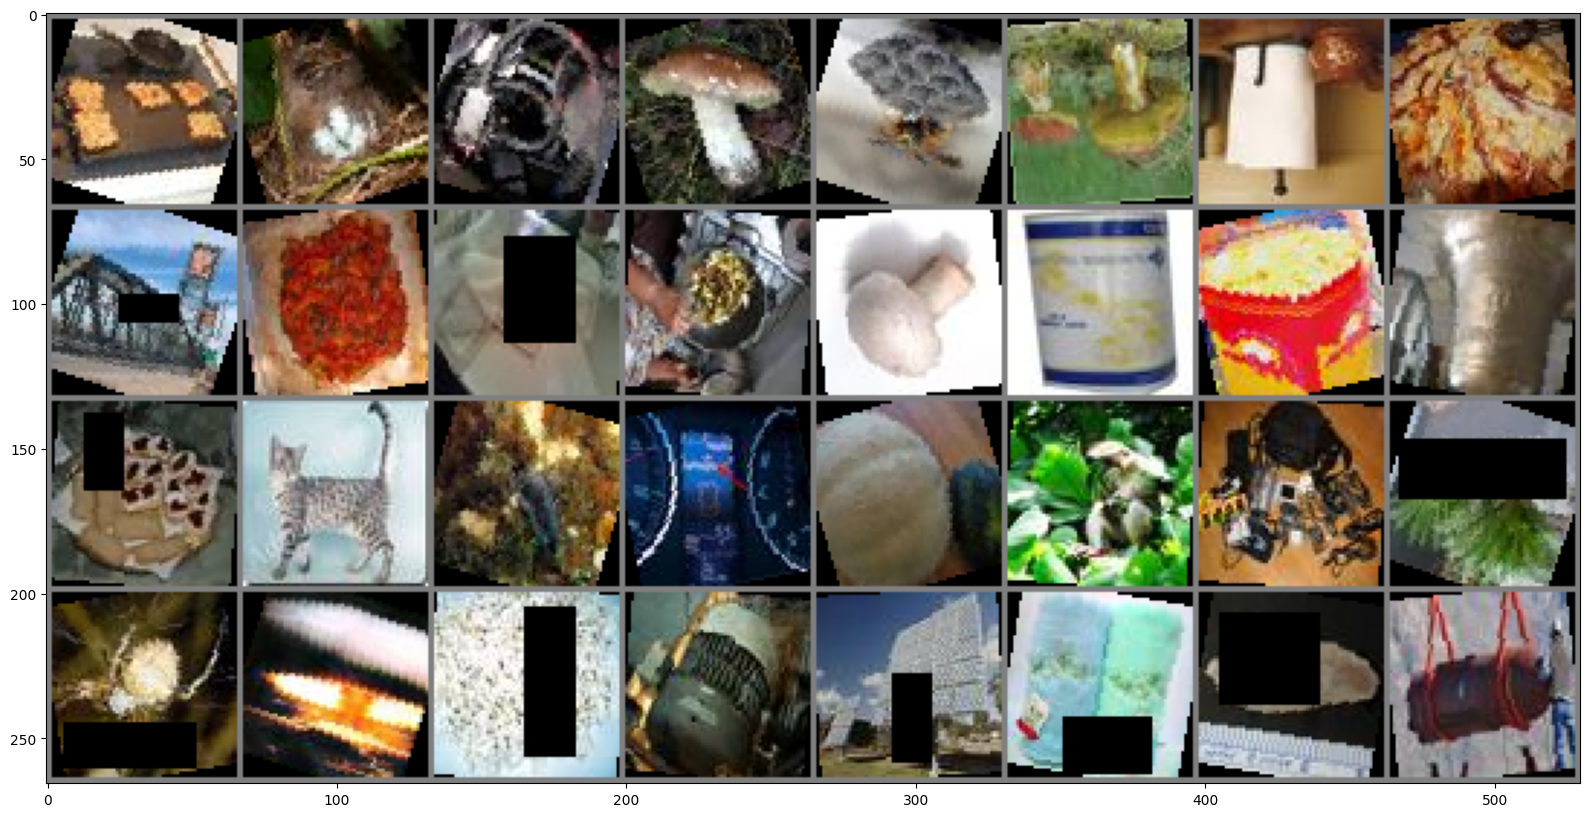

bread  nest motor fungus  nest fungus towel pizza bridge pizza towel spice fungus towel  corn acoustic bread   cat  worm gauge squash monkey battery  palm spider  bomb  corn motor antenna towel  worm  bomb


In [9]:
plt.figure(figsize = (20,10))
images, labels = next(iter(train_loader))
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % raw_train_set.classes[labels[j]] for j in range(BATCH_SIZE)))

In [10]:
def peek_class(class_name, dataset, img_num):
    cls_idx = raw_train_set.class_to_idx[class_name]
    data_indexes = [idx for idx, img_idx_tuple in enumerate(dataset.imgs) if img_idx_tuple[1] == cls_idx]
    class_set = Subset(dataset, data_indexes)
    class_loader = DataLoader(class_set, batch_size=img_num,
                              shuffle=True, num_workers=2)
    images, labels = next(iter(class_loader))
    plt.figure(figsize=(20,10))
    imshow(torchvision.utils.make_grid(images))
    print(' '.join('%5s' % raw_train_set.classes[labels[j]] for j in range(img_num)))

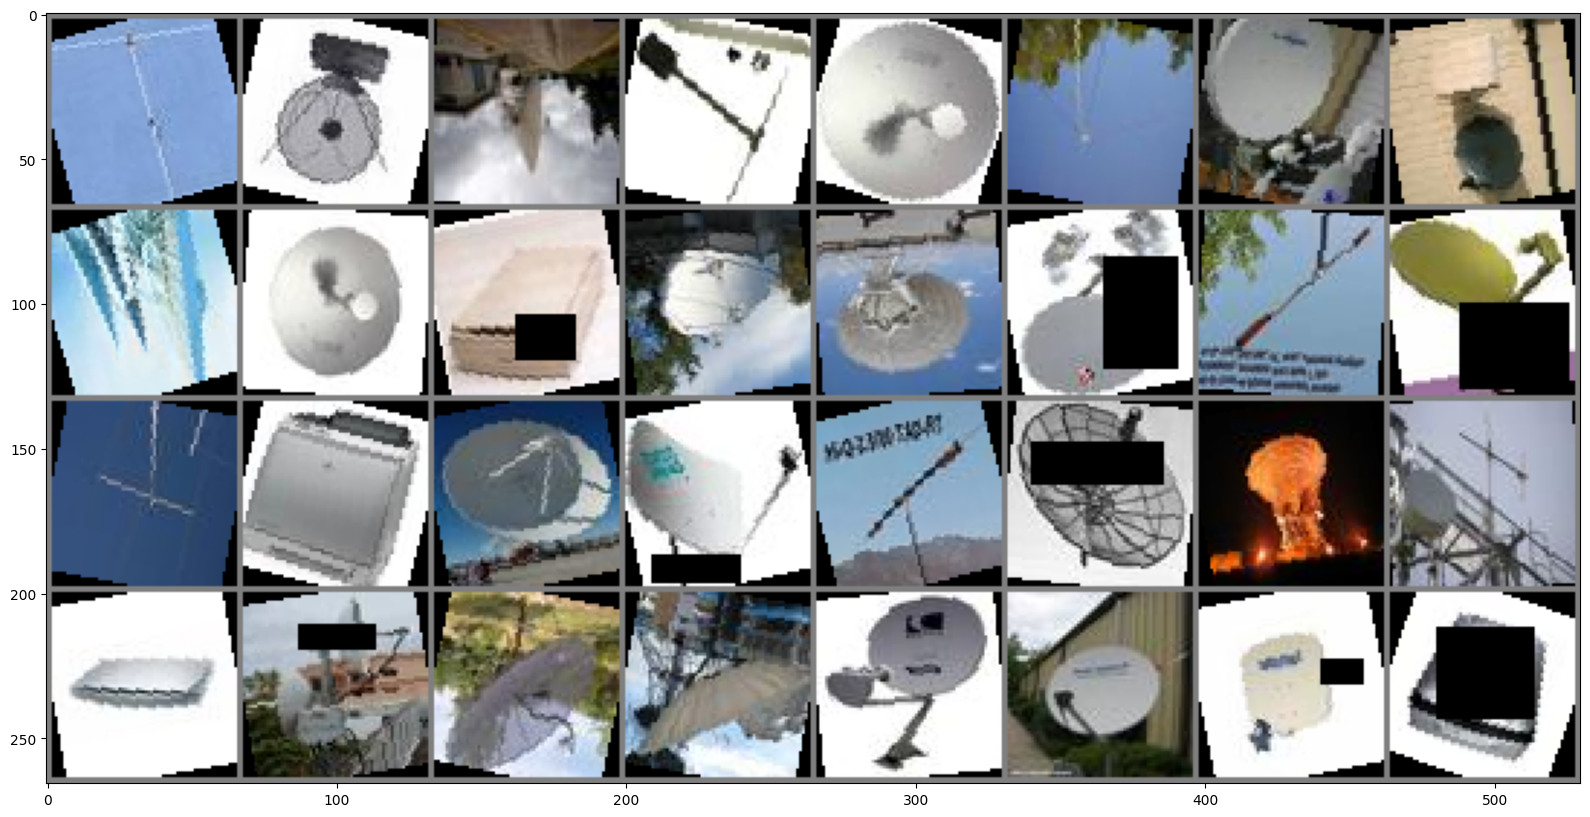

antenna antenna antenna antenna antenna antenna antenna antenna antenna antenna antenna antenna antenna antenna antenna antenna antenna antenna antenna antenna antenna antenna antenna antenna antenna antenna antenna antenna antenna antenna antenna antenna


In [11]:
peek_class("antenna", raw_train_set, 32)

### Sprawdzenie rozmiaru obrazu

In [12]:
images[0:1].size()

torch.Size([1, 3, 64, 64])

#### Na pierwszy rzut oka widać że niektóre przykłady nie mają sensu nawet dla człowieka, więc może się zdarzyc tak, że trening że część przykładów nie będzie się dawała dotrenować.

### Pętla treningowa

In [13]:
def train(model, optimizer, criterion, epoch_num, train_loader, test_loader):
    train_batch_num, test_batch_num = len(train_loader), len(test_loader)

    for epoch in range(epoch_num): 
        print(f"[{epoch + 1}/{epoch_num}]")
        # train
        model.train()

        train_progress_bar = tqdm(total=train_batch_num)
        batch_loss, batch_accuracy, batch_correct_sum, train_running_loss_sum, train_running_loss, train_running_accuracy, train_correct_sum, train_sample_sum = 0, 0, 0, 0, 0, 0, 0, 0
        for batch_num, data in enumerate(train_loader, 1):
            inputs, labels = data
            train_sample_sum += len(inputs)
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_loss = loss.item()
            train_running_loss_sum += batch_loss
            train_running_loss = train_running_loss_sum/batch_num


            _, predicted = torch.max(outputs, 1)
            batch_correct_sum = (predicted == labels).sum()
            train_correct_sum += batch_correct_sum
            train_running_accuracy = train_correct_sum/train_sample_sum
            batch_accuracy = batch_correct_sum/len(inputs)

            train_progress_bar.update(1)
            train_progress_bar.set_description(f"TRAINING: current batch loss = {batch_loss:.2f}, current batch accuracy = {batch_accuracy:.2f}, running loss = {train_running_loss:.2f}, running accuracy = {train_running_accuracy:.2f}")

        # eval
        model.eval()

        test_progress_bar = tqdm(total=test_batch_num)
        batch_loss, batch_accuracy, batch_correct_sum, test_running_loss_sum, test_running_loss, test_running_accuracy, test_correct_sum, test_sample_sum = 0, 0, 0, 0, 0, 0, 0, 0
        for batch_num, data in enumerate(test_loader, 1):
            inputs, labels = data
            test_sample_sum += len(inputs)
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            batch_loss = loss.item()
            test_running_loss_sum += batch_loss
            test_running_loss = test_running_loss_sum/batch_num

            _, predicted = torch.max(outputs, 1)
            batch_correct_sum = (predicted == labels).sum()
            test_correct_sum += batch_correct_sum
            test_running_accuracy = test_correct_sum/test_sample_sum
            batch_accuracy = batch_correct_sum/len(inputs)

            test_progress_bar.set_description(f"VALIDATION: current batch loss = {batch_loss:.2f}, current batch accuracy = {batch_accuracy:.2f},\n running loss = {test_running_loss:.2f}, running accuracy = {test_running_accuracy:.2f}")
            test_progress_bar.update(1)

In [14]:
def check_class_accuracy(model, classes, data_loader):
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    with torch.no_grad():
        model.eval()
        
        checking_progress_bar = tqdm(total=len(data_loader))
        for data in data_loader:
            images, labels = data    
            images = images.to(device)
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1
            checking_progress_bar.update(1)

    accuracy = {classname: correct_count/total_count for classname, correct_count, total_count in zip(classes, correct_pred.values(), total_pred.values())}
    return accuracy

In [15]:
model = models.resnet50()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [1]:
train(model, optimizer, criterion, 20, train_loader, test_loader)
torch.save(model.state_dict(), "resnet50_20epochs.pth")

NameError: name 'train' is not defined

In [ ]:
acc_dict = check_class_accuracy(model, raw_train_set.classes, test_loader)

  0%|          | 0/551 [00:00<?, ?it/s]

In [ ]:
for name, acc in sorted(list(acc_dict.items()), key=lambda x: x[1]):
    print(f"{name}: {acc:.2f}")

icecream: 0.13
acoustic: 0.14
bird: 0.19
crab: 0.19
frog: 0.20
snake: 0.22
battery: 0.22
kangaroo: 0.22
carbon: 0.26
pot: 0.26
nest: 0.26
echinoderm: 0.31
worm: 0.32
antenna: 0.33
gauge: 0.34
tea: 0.34
bread: 0.35
turtle: 0.35
bomb: 0.37
bean: 0.38
monkey: 0.38
towel: 0.40
motor: 0.41
egg: 0.42
crocodilian: 0.42
cat: 0.42
corn: 0.44
bacteria: 0.46
camera: 0.47
swine: 0.48
fish: 0.49
spice: 0.50
saw: 0.50
bridge: 0.51
squash: 0.51
printer: 0.51
birch: 0.51
fungus: 0.53
truck: 0.54
spider: 0.54
bicycle: 0.57
palm: 0.57
beetle: 0.60
elephant: 0.60
hammer: 0.61
spoon: 0.62
memorial: 0.66
tomato: 0.66
pizza: 0.76
flower: 0.90
